# tidal analysis

Test utide [github rep](https://github.com/wesleybowman/UTide)

Note that I fixed several issues, so you need to install the [forked rep](https://github.com/apatlpo/UTide)


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import datetime, dateutil

import utide

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 2
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    local_dir = os.getenv('TMPDIR')
    cluster = PBSCluster(local_directory=local_dir)
    #print(cluster.job_script())
    w = cluster.start_workers(10)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [10]:
client

Client Scheduler: tcp://10.148.1.25:58408 Dashboard: http://10.148.1.25:60216/status,Cluster Workers: 8 Cores: 32 Memory: 400.00 GB


---

# 0: variable select and path


In [11]:
v = 'Eta'

## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
#ncdata_dir = scratch+'/mit_nc_t/'
ncdata_dir = osi+'/mit_nc_t/'

# dir where filtered data is stored
out_dir = osi+'/mit_filtered/'

--- 

# 1: One face 

## load data

In [12]:
face = 1

# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[:2] # tmp
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset(osi+'mit_grid_t.nc')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 34
Number of files processed: 34
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [13]:
%time ds0 = xr.open_mfdataset(filenames, chunks={'i':10}, concat_dim='time', compat='equals')

ds = ds0

# !!! tmp (waiting for data to be reprocessed) !!!
#ds = ds.assign_coords(time_days=ds['time']/86400.)
ds = ds.assign_coords(dtime=xr.DataArray(iters_to_date(ds.time.values/25.), dims=['time']))
# !!!

ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 672 ms, sys: 252 ms, total: 924 ms
Wall time: 3.78 s
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    dtime    (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 4320, 240)>

 data size: 609.4 GB


In [14]:
# chunks probably need to be larger than window size but don't need to run over the full time series
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 148 ms, sys: 4 ms, total: 152 ms
Wall time: 153 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 8160)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    dtime    (time) datetime64[ns] dask.array<shape=(8160,), chunksize=(8160,)>
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    rA       (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    Depth    (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 8160), chunksize=(10, 4320, 8160)>


---

## tidal analysis @ 1 location

In [15]:
lds = ds.isel(i=0, j=0).isel(time=slice(0,3000))
eta = lds.Eta.values
lat = grid.YC.isel(i=0, j=0).values
print(lds)
print('\nlat = %f' %lat)

<xarray.Dataset>
Dimensions:  (time: 3000)
Coordinates:
    i        int64 0
    j        int64 0
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    dtime    (time) datetime64[ns] dask.array<shape=(3000,), chunksize=(3000,)>
    XC       float32 dask.array<shape=(), chunksize=()>
    YC       float32 dask.array<shape=(), chunksize=()>
    rA       float32 dask.array<shape=(), chunksize=()>
    Depth    float32 dask.array<shape=(), chunksize=()>
Data variables:
    Eta      (time) float32 dask.array<shape=(3000,), chunksize=(3000,)>

lat = -57.001026


In [16]:
#t0 = datetime.datetime(2011,9,10)
#dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t.values) for t in lds.time]
mtime = mdates.date2num(lds.dtime)

In [17]:
coef = utide.solve(mtime, eta,
                   lat=lat,
                   method='ols',
                   conf_int='MC')

solve: matrix prep ... solution ... diagnostics ... done.


In [18]:
coef

{'name': array(['K1', 'S2', 'O1', 'M2', 'Q1', 'MSF', 'N2', 'J1', 'NO1', 'MM',
        '2Q1', 'L2', 'ETA2', 'OO1', 'M6', 'UPS1', 'M4', 'ALP1', 'MU2',
        'MS4', '2MN6', 'MN4', 'EPS2', '2MS6', 'MO3', 'SK3', 'MK3', '2SM6',
        'M3', '2SK5', 'S4', '2MK5', 'M8', '3MK7', 'SN4'], dtype=object),
 'aux': {'frq': array([0.04178075, 0.08333333, 0.03873065, 0.0805114 , 0.0372185 ,
         0.00282193, 0.07899925, 0.0432929 , 0.04026859, 0.00151215,
         0.03570635, 0.08202355, 0.08507364, 0.04483084, 0.2415342 ,
         0.04634299, 0.1610228 , 0.03439657, 0.07768947, 0.16384473,
         0.24002205, 0.15951065, 0.07617732, 0.24435613, 0.11924206,
         0.12511408, 0.12229215, 0.24717807, 0.1207671 , 0.20844741,
         0.16666667, 0.20280355, 0.3220456 , 0.28331495, 0.16233258]),
  'lind': array([ 20,  56,  12,  47,  10,   5,  41,  24,  15,   4,   8,  53,  60,
          27, 105,  28,  81,   7,  39,  85, 102,  78,  34, 109,  67,  73,
          71, 112,  68,  98,  88,  95, 124, 119,

In [19]:
eta_tide = utide.reconstruct(mtime, coef)

prep/calcs ... done.


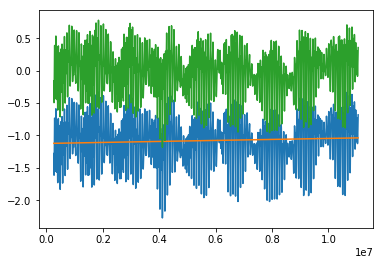

In [20]:
ax=plt.subplot(111)
ax.plot(lds.time, eta)
ax.plot(lds.time, eta_tide.h)
ax.plot(lds.time, eta-eta_tide.h)

In [21]:
# extract particular harmonics
[a for n, a in zip(coef.name, coef.A) if n in ['M2','S2']]

[0.2409121866419189, 0.16743180222620152]

---

# analyze a larger area

In [22]:
#lds = ds.isel(i=slice(10), j=slice(10)).isel(time=slice(0,3000))
lds = ds.isel(i=slice(10), time=slice(0,3000))

In [26]:
cst = ['M2', 'S2']

# with apply_ufunc, cannot output multiple variables
def process(v, dtime, lat):
    #
    #m = str(v.shape) #(10, 10, 3000)
    #
    #t0 = datetime.datetime(2011,9,10)
    #dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in time]
    mtime = mdates.date2num(dtime)
    #
    A = np.zeros((v.shape[0], v.shape[1], len(cst)))
    #A = np.zeros((v.shape[0], v.shape[1]))
    #
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            coef = utide.solve(mtime, v[i,j,:], lat=lat[i,j], \
                               method='ols', conf_int='MC')
            for n, a, g in zip(coef.name, coef.A, coef.g):
                if n in cst:
                    #A[i, j] = a
                    A[i, j, cst.index(n)] = a
                    #G[i, j, cst.index(n)] = g
    #
    return A


#input_core_dims=[['i', 'j', 'time'], ['time'], ['i', 'j']], 
#                   input_core_dims=[['i', 'j'], [], ['i', 'j']], 
#                   output_core_dims=[['i','j', 'constituent']],

eta = lds['Eta'].fillna(0.)
#here fill 
lat = lds['YC'] #.fillna(10.)

M = xr.apply_ufunc(process, eta, lds['dtime'], lat,
                   dask='parallelized', output_dtypes=[float],
                   input_core_dims=[['time'], ['time'], []],
                   output_core_dims=[['constituent']],
                   output_sizes={'constituent': len(cst)})
#M = xr.apply_ufunc(process, lds['Eta'], lds['time'],
#                   input_core_dims=[['i','j','time'],['time']], 
#                   dask='parallelized', output_dtypes=[str])
M = M.assign_coords(constituent=cst).rename('A').to_dataset()
print(M)


<xarray.Dataset>
Dimensions:      (constituent: 2, i: 10, j: 4320)
Coordinates:
  * i            (i) int64 0 1 2 3 4 5 6 7 8 9
  * j            (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face         int64 1
    XC           (i, j) float32 dask.array<shape=(10, 4320), chunksize=(10, 4320)>
    YC           (i, j) float32 dask.array<shape=(10, 4320), chunksize=(10, 4320)>
    rA           (i, j) float32 dask.array<shape=(10, 4320), chunksize=(10, 4320)>
    Depth        (i, j) float32 dask.array<shape=(10, 4320), chunksize=(10, 4320)>
  * constituent  (constituent) <U2 'M2' 'S2'
Data variables:
    A            (i, j, constituent) float64 dask.array<shape=(10, 4320, 2), chunksize=(10, 4320, 2)>


In [27]:
M.A.sel(constituent='M2').plot()

KeyboardInterrupt: 

---

In [120]:
# kill workers
cluster.stop_workers(cluster.jobs)

In [80]:
# add workers
w = cluster.start_workers(10)

In [78]:
# restart workers
client.restart()

Client Scheduler: tcp://10.148.1.0:57813 Dashboard: http://10.148.1.0:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B
